# Load QED-CCSD Data
This data considers the energy of the meta and ortho intermediates with a fixed geometry and different orientations of the field (by $\theta$ and $\phi$ values), which is equivalent to a rigid rotation about the field axis.

The following cell will load and interpolate this data on a $\theta,\phi$ grid.

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

Loading META dataset...
Loading ORTHO dataset...
Loading NITRO dataset...

Processing: META CCSD
Data points: 576
Theta range: [0.0000, 180.0000]
Phi range: [0.0000, 360.0000]
Value range: [-3.007841e+03, -3.007754e+03]

Interpolation Accuracy Assessment:
------------------------------------------------------------
Successfully interpolated: 576/576

Absolute Error Statistics:
  Mean: 1.342136e-14
  Std:  7.696230e-14
  Max:  4.547474e-13


/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_41667/2060206455.py:121: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ortho_df = pd.read_csv('CCSD_DATA/ortho_ccsd_energies.txt', delim_whitespace=True,


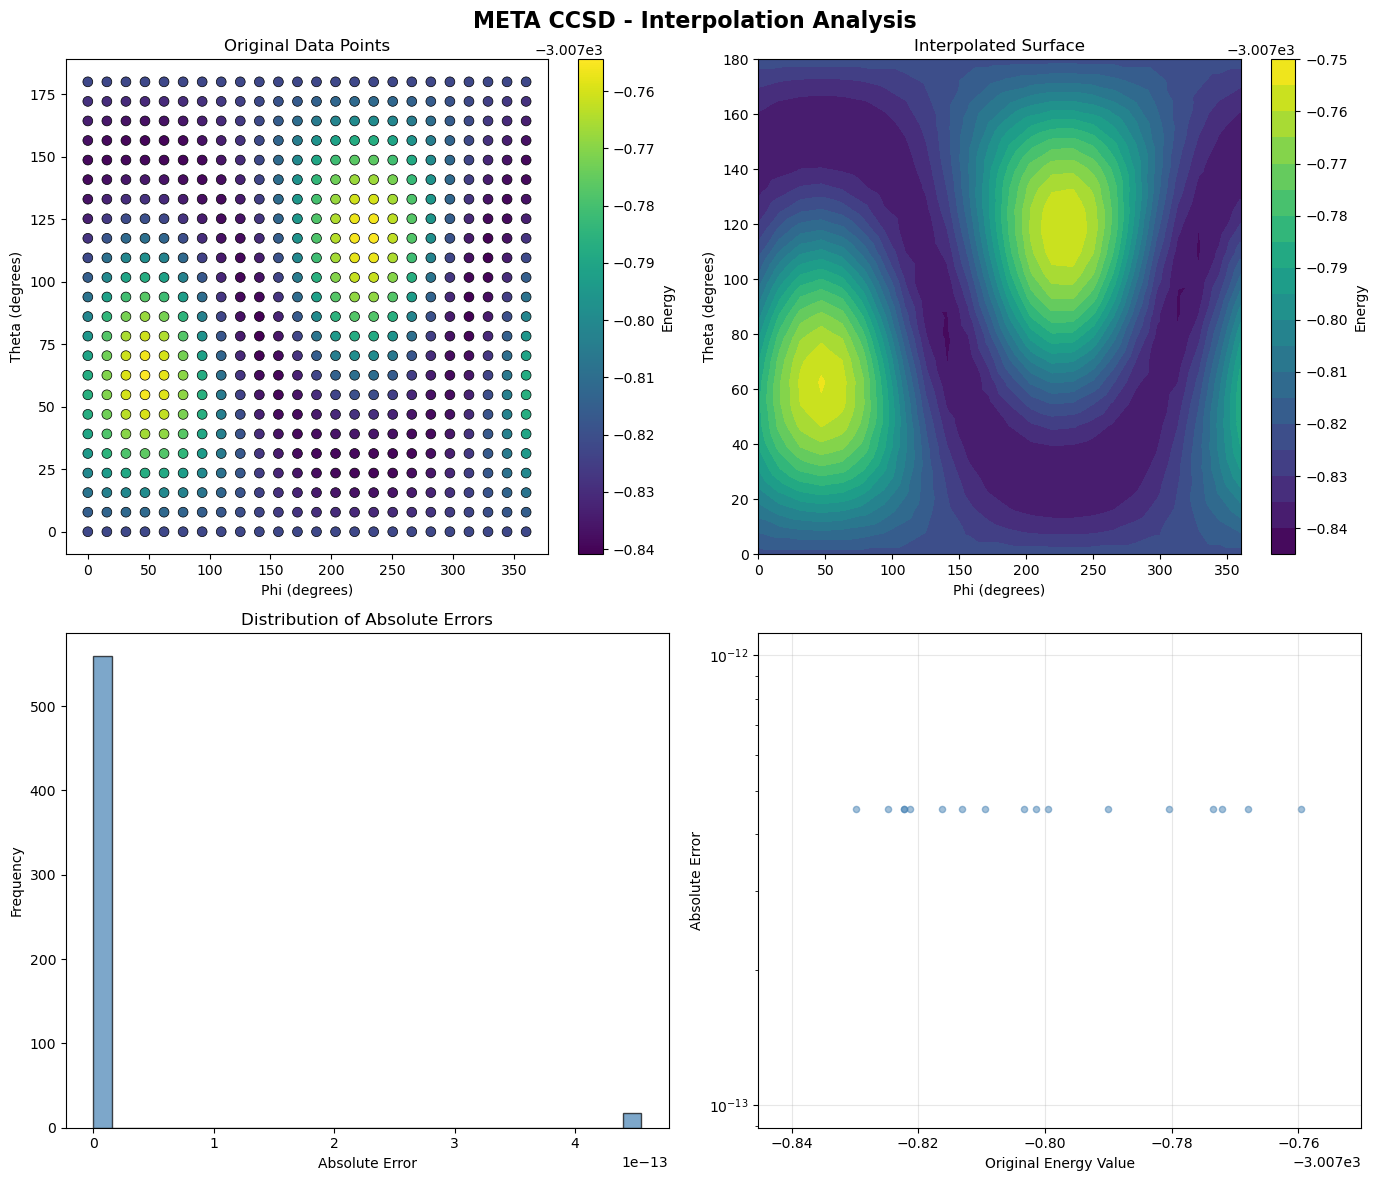


Processing: ORTHO CCSD
Data points: 576
Theta range: [0.0000, 180.0000]
Phi range: [0.0000, 360.0000]
Value range: [-3.007838e+03, -3.007778e+03]

Interpolation Accuracy Assessment:
------------------------------------------------------------
Successfully interpolated: 576/576

Absolute Error Statistics:
  Mean: 1.342136e-14
  Std:  7.696230e-14
  Max:  4.547474e-13


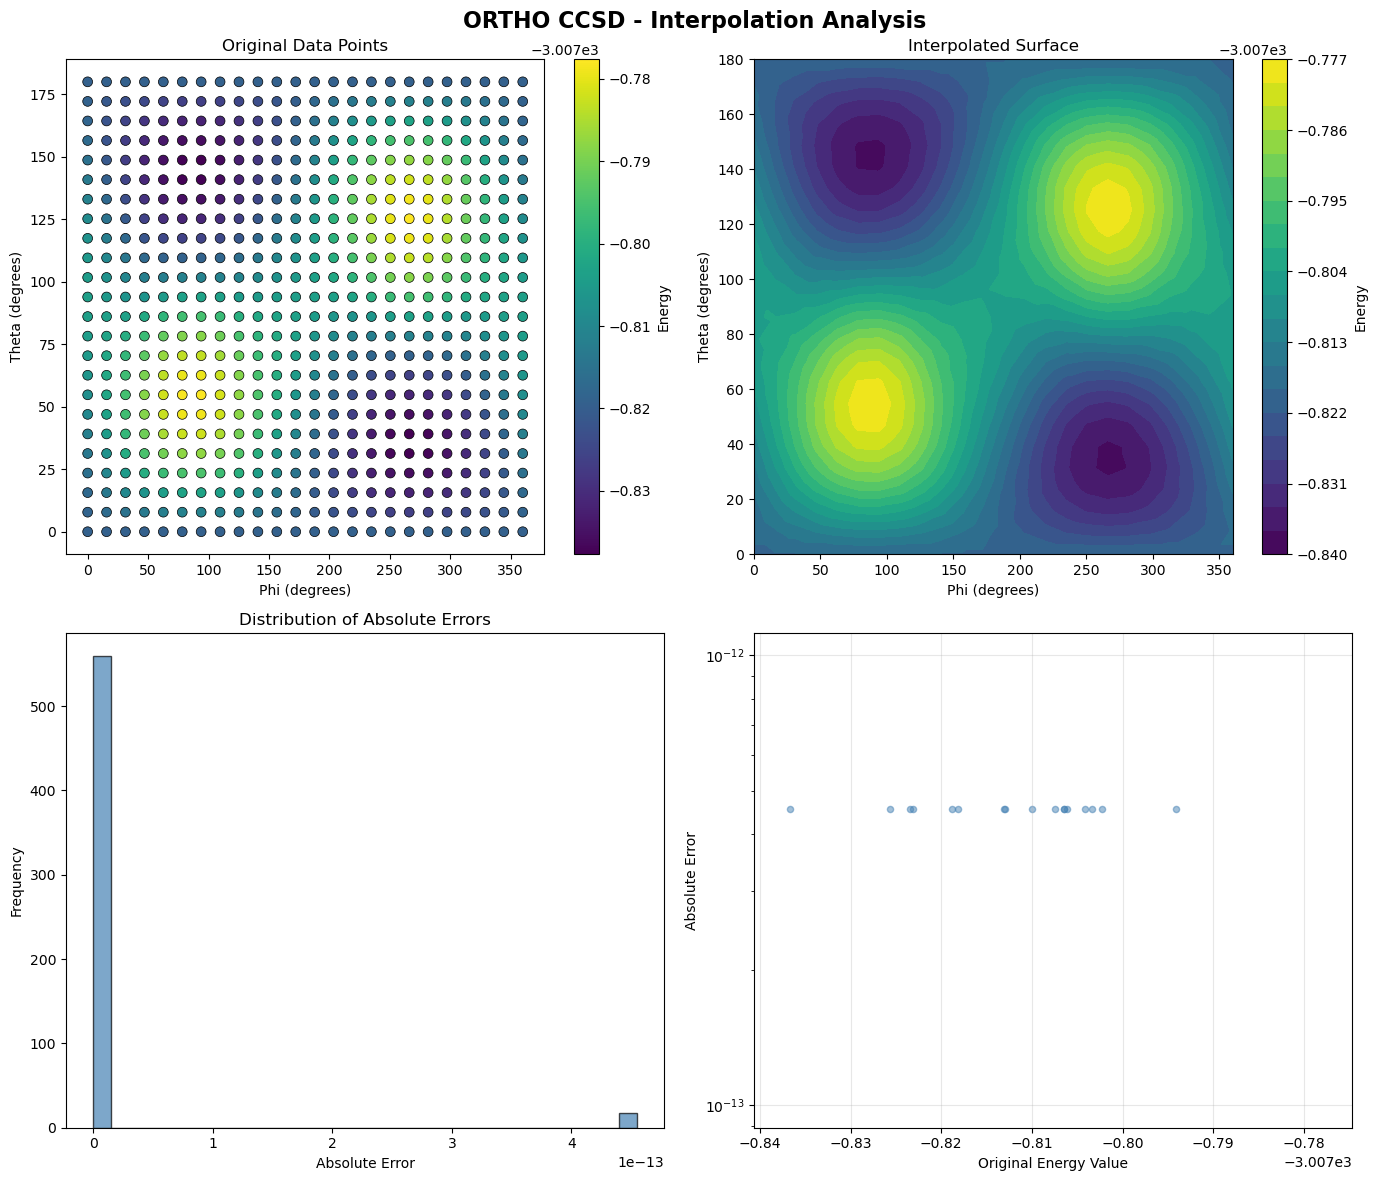


Processing: NITRO Field Scan
Data points: 625
Theta range: [0.0000, 180.0000]
Phi range: [0.0000, 360.0000]
Value range: [-4.341258e+02, -4.340787e+02]

Interpolation Accuracy Assessment:
------------------------------------------------------------
Successfully interpolated: 625/625

Absolute Error Statistics:
  Mean: 0.000000e+00
  Std:  0.000000e+00
  Max:  0.000000e+00


/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_41667/2060206455.py:91: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1, 1].set_yscale('log')


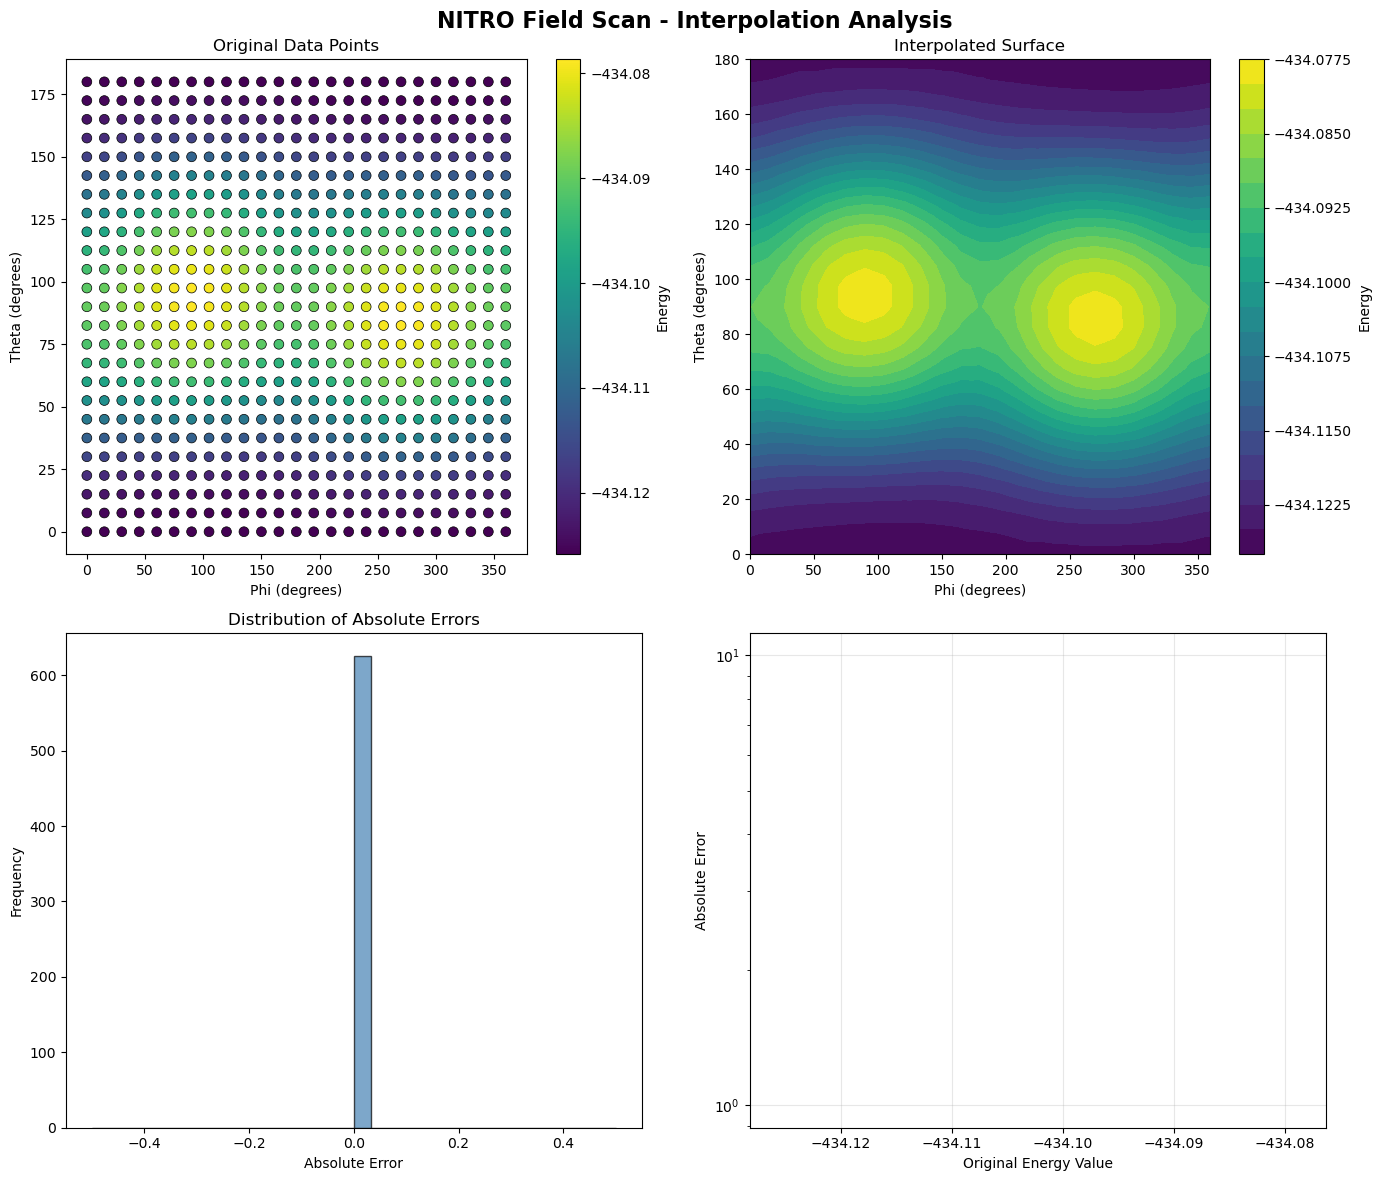


COMPARISON SUMMARY

Dataset              Points     Valid      Mean Abs Err    Mean Rel Err % 
--------------------------------------------------------------------------------
META CCSD            576        576        1.342136e-14    0.0000         
ORTHO CCSD           576        576        1.342136e-14    0.0000         
NITRO Field Scan     625        625        0.000000e+00    0.0000         


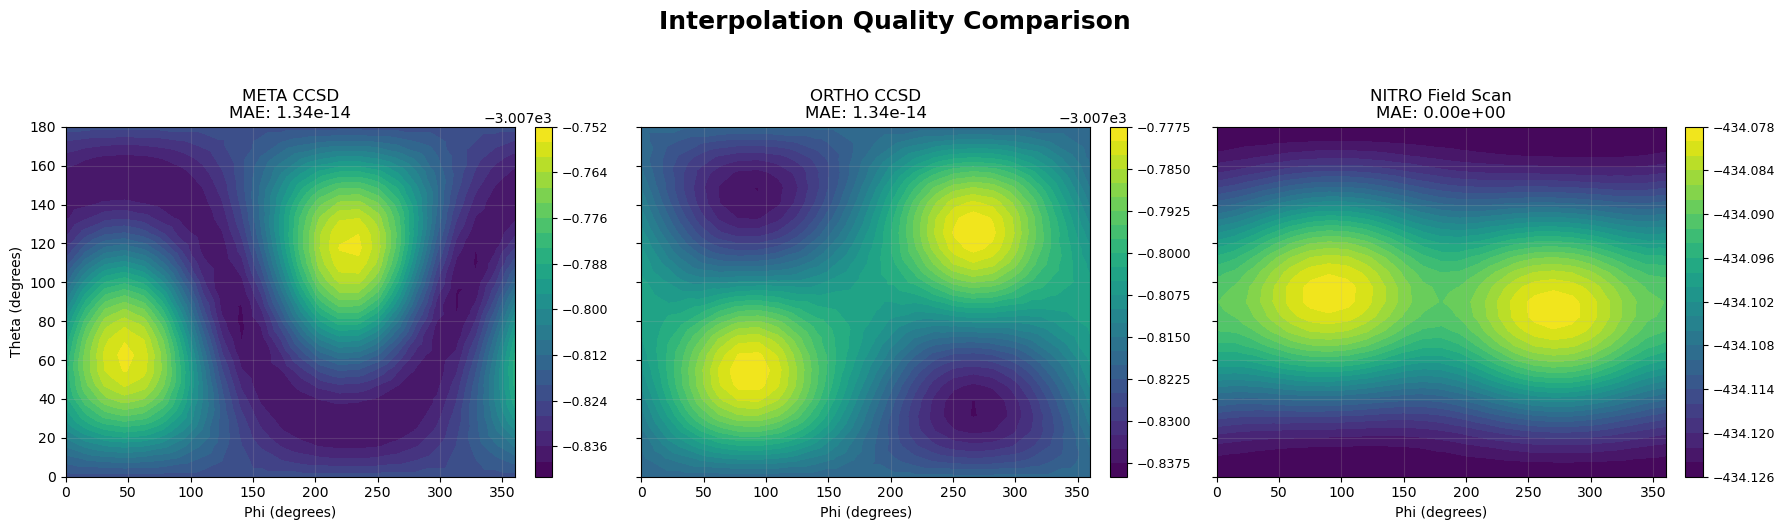


Analysis complete!


In [2]:
### THIS CELL READS FROM ORTHO, META, AND NITRO!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def load_and_analyze_dataset(df, dataset_name, n_grid_points=24):
    """
    Perform interpolation and accuracy analysis on a molecular energy dataset.
    """
    print(f"\n{'='*60}")
    print(f"Processing: {dataset_name}")
    print(f"{'='*60}")
    
    # Extract values
    theta_vals = df['theta'].values
    phi_vals = df['phi'].values
    values = df['value'].values
    
    print(f"Data points: {len(values)}")
    print(f"Theta range: [{theta_vals.min():.4f}, {theta_vals.max():.4f}]")
    print(f"Phi range: [{phi_vals.min():.4f}, {phi_vals.max():.4f}]")
    print(f"Value range: [{values.min():.6e}, {values.max():.6e}]")
    
    # Create pivot table for internal tracking
    pivot_df = df.pivot_table(index='theta', columns='phi', values='value')
    pivot_df.index = pivot_df.index.round(4)
    pivot_df.columns = pivot_df.columns.round(4)
    
    # Create fine grid for interpolation
    phi_grid = np.linspace(phi_vals.min(), phi_vals.max(), n_grid_points)
    theta_grid = np.linspace(theta_vals.min(), theta_vals.max(), n_grid_points)
    PH, TH = np.meshgrid(phi_grid, theta_grid)
    
    # Perform interpolation on grid
    grid_values = griddata((phi_vals, theta_vals), values, 
                          (PH, TH), method='linear')
    
    # Test accuracy: interpolate at original data points
    interpolated_at_original = griddata((phi_vals, theta_vals), values,
                                       (phi_vals, theta_vals), method='linear')
    
    # Calculate errors
    absolute_errors = np.abs(values - interpolated_at_original)
    relative_errors = np.abs((values - interpolated_at_original) / values) * 100
    
    # Remove NaN values (edge points)
    valid_mask = ~np.isnan(interpolated_at_original)
    absolute_errors_clean = absolute_errors[valid_mask]
    relative_errors_clean = relative_errors[valid_mask]
    values_clean = values[valid_mask]
    
    # Print statistics
    print(f"\nInterpolation Accuracy Assessment:")
    print(f"{'-'*60}")
    print(f"Successfully interpolated: {np.sum(valid_mask)}/{len(values)}")
    print(f"\nAbsolute Error Statistics:")
    print(f"  Mean: {np.mean(absolute_errors_clean):.6e}")
    print(f"  Std:  {np.std(absolute_errors_clean):.6e}")
    print(f"  Max:  {np.max(absolute_errors_clean):.6e}")
    
    # Visualization for this specific dataset
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'{dataset_name} - Interpolation Analysis', fontsize=16, fontweight='bold')
    
    # 1. Original data scatter
    scatter = axes[0, 0].scatter(df['phi'], df['theta'], c=df['value'], 
                                cmap='viridis', s=50, edgecolors='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Phi (degrees)')
    axes[0, 0].set_ylabel('Theta (degrees)')
    axes[0, 0].set_title('Original Data Points')
    plt.colorbar(scatter, ax=axes[0, 0], label='Energy')
    
    # 2. Interpolated surface
    contour = axes[0, 1].contourf(PH, TH, grid_values, levels=20, cmap='viridis')
    axes[0, 1].set_xlabel('Phi (degrees)')
    axes[0, 1].set_ylabel('Theta (degrees)')
    axes[0, 1].set_title('Interpolated Surface')
    plt.colorbar(contour, ax=axes[0, 1], label='Energy')
    
    # 3. Absolute error distribution
    axes[1, 0].hist(absolute_errors_clean, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1, 0].set_xlabel('Absolute Error')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Absolute Errors')
    
    # 4. Error vs original value
    axes[1, 1].scatter(values_clean, absolute_errors_clean, alpha=0.5, s=20, color='steelblue')
    axes[1, 1].set_xlabel('Original Energy Value')
    axes[1, 1].set_ylabel('Absolute Error')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'dataset_name': dataset_name,
        'PH': PH, 'TH': TH,
        'grid_values': grid_values,
        'mean_abs_error': np.mean(absolute_errors_clean),
        'mean_rel_error': np.mean(relative_errors_clean),
        'phi_grid' : phi_grid,
        'theta_grid' : theta_grid,
        'n_valid': np.sum(valid_mask),
        'n_total': len(values)
    }

# ===== 1. LOAD ALL DATASETS =====

# META dataset
print("Loading META dataset...")
meta_df = pd.read_csv('CCSD_DATA/meta_ccsd_energies.txt', sep='\s+', header=None, 
                      names=['filename', 'value'])
pattern = r"theta_(.*?)_phi_(.*?)\.json"
meta_df[['theta', 'phi']] = meta_df['filename'].str.extract(pattern).astype(float)
meta_df = meta_df[['theta', 'phi', 'value']]

# ORTHO dataset
print("Loading ORTHO dataset...")
ortho_df = pd.read_csv('CCSD_DATA/ortho_ccsd_energies.txt', delim_whitespace=True,
                       header=None, names=['theta', 'phi', 'value'])

# NITRO dataset (NEW)
print("Loading NITRO dataset...")
nitro_df = pd.read_csv('CCSD_DATA/nitro_field_scan_results.txt', 
                       sep='\s+', 
                       comment='#', 
                       header=None, 
                       names=['theta', 'phi', 'x', 'y', 'z', 'value'])
nitro_df = nitro_df[['theta', 'phi', 'value']]

# ===== 2. ANALYZE ALL DATASETS =====

meta_results = load_and_analyze_dataset(meta_df, "META CCSD", n_grid_points=500)
ortho_results = load_and_analyze_dataset(ortho_df, "ORTHO CCSD", n_grid_points=500)
nitro_results = load_and_analyze_dataset(nitro_df, "NITRO Field Scan", n_grid_points=500)

# ===== 3. COMPARISON SUMMARY =====

print(f"\n{'='*60}")
print("COMPARISON SUMMARY")
print(f"{'='*60}")

results_list = [meta_results, ortho_results, nitro_results]

print(f"\n{'Dataset':<20} {'Points':<10} {'Valid':<10} {'Mean Abs Err':<15} {'Mean Rel Err %':<15}")
print(f"{'-'*80}")
for r in results_list:
    print(f"{r['dataset_name']:<20} {r['n_total']:<10} {r['n_valid']:<10} "
          f"{r['mean_abs_error']:<15.6e} {r['mean_rel_error']:<15.4f}")

# Dynamic plot layout
num_plots = len(results_list)
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)
fig.suptitle('Interpolation Quality Comparison', fontsize=18, fontweight='bold', y=1.05)

for i, r in enumerate(results_list):
    ax = axes[i]
    cp = ax.contourf(r['PH'], r['TH'], r['grid_values'], levels=25, cmap='viridis')
    
    # Add colorbar for energy range
    cbar = fig.colorbar(cp, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    
    ax.set_xlabel('Phi (degrees)')
    if i == 0: ax.set_ylabel('Theta (degrees)')
    ax.set_title(f"{r['dataset_name']}\nMAE: {r['mean_abs_error']:.2e}")
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")

In [3]:
hartree_to_kcalmol = 627.5094740631

o_vals, phi_grid, theta_grid = ortho_results['grid_values'], ortho_results['phi_grid'],  ortho_results['theta_grid']
m_vals = meta_results['grid_values']

# Compute gradients on the entire grid
dE_dtheta_ortho, dE_dphi_ortho = np.gradient(o_vals, theta_grid, phi_grid)
dE_dtheta_meta, dE_dphi_meta = np.gradient(m_vals, theta_grid, phi_grid)

theta_central = 74.1  # 74.1° from z-axis
phi_central = 35.0    # 35° from x-axis in xy-plane

# Find nearest grid indices
phi_idx = np.argmin(np.abs(phi_grid - phi_central))
theta_idx = np.argmin(np.abs(theta_grid - theta_central))

# CORRECT indexing: [theta_idx, phi_idx] because theta is rows, phi is columns
ortho_gradient_phi = dE_dphi_ortho[theta_idx, phi_idx]
ortho_gradient_theta = dE_dtheta_ortho[theta_idx, phi_idx]
ortho_val = o_vals[theta_idx, phi_idx]

# Use the META gradients here (not ortho!)
meta_gradient_phi = dE_dphi_meta[theta_idx, phi_idx]
meta_gradient_theta = dE_dtheta_meta[theta_idx, phi_idx]
meta_val = m_vals[theta_idx, phi_idx]

# Convert from hartree/degree to hartree/radian
#gradient_per_radian = gradient_per_degree * (np.pi / 180)
conversion_factor = 180 / np.pi  # degrees per radian

ortho_gradient_phi_rad = ortho_gradient_phi * conversion_factor
ortho_gradient_theta_rad = ortho_gradient_theta * conversion_factor
meta_gradient_phi_rad = meta_gradient_phi * conversion_factor
meta_gradient_theta_rad = meta_gradient_theta * conversion_factor


print(f"At phi={phi_grid[phi_idx]:.2f}, theta={theta_grid[theta_idx]:.2f}:")
print(f"  Ortho  E     = {ortho_val:.6e}")
print(f"  Ortho ∂E/∂φ  = {ortho_gradient_phi_rad:.6e}")
print(f"  Ortho ∂E/∂θ  = {ortho_gradient_theta_rad:.6e}")
print(f"  Meta   E     = {meta_val:.6e}")
print(f"  Meta  ∂E/∂φ  = {meta_gradient_phi_rad:.6e}")
print(f"  Meta  ∂E/∂θ  = {meta_gradient_theta_rad:.6e}")
print(f"  Ortho-Meta E = {(ortho_val-meta_val)*hartree_to_kcalmol:.2f} eV")



At phi=35.35, theta=73.95:
  Ortho  E     = -3.007798e+03
  Ortho ∂E/∂φ  = 1.905760e-02
  Ortho ∂E/∂θ  = -1.785254e-02
  Meta   E     = -3.007762e+03
  Meta  ∂E/∂φ  = 1.690466e-02
  Meta  ∂E/∂θ  = -3.242401e-02
  Ortho-Meta E = -22.56 eV


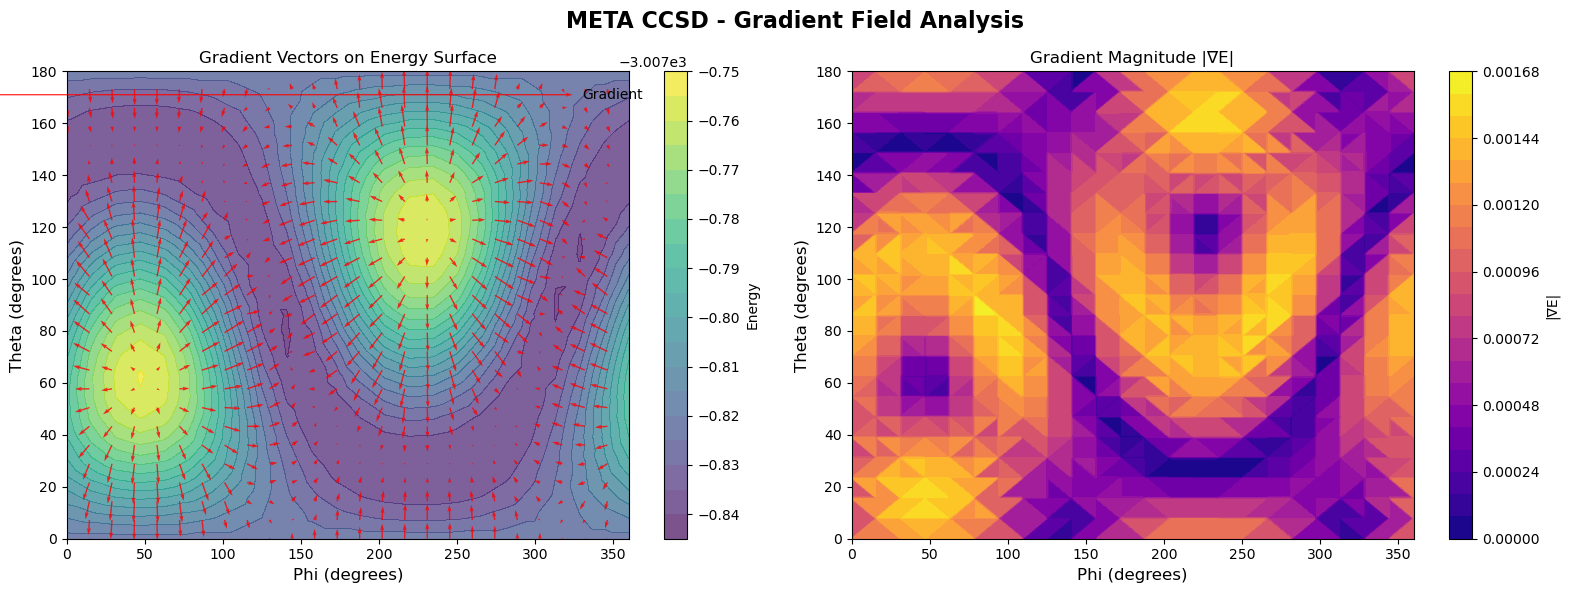


Gradient Statistics for META CCSD:
------------------------------------------------------------
∂E/∂φ range: [-1.240679e-03, 1.374299e-03]
∂E/∂θ range: [-1.549631e-03, 1.537248e-03]
|∇E| mean: 8.405018e-04
|∇E| max: 1.605639e-03


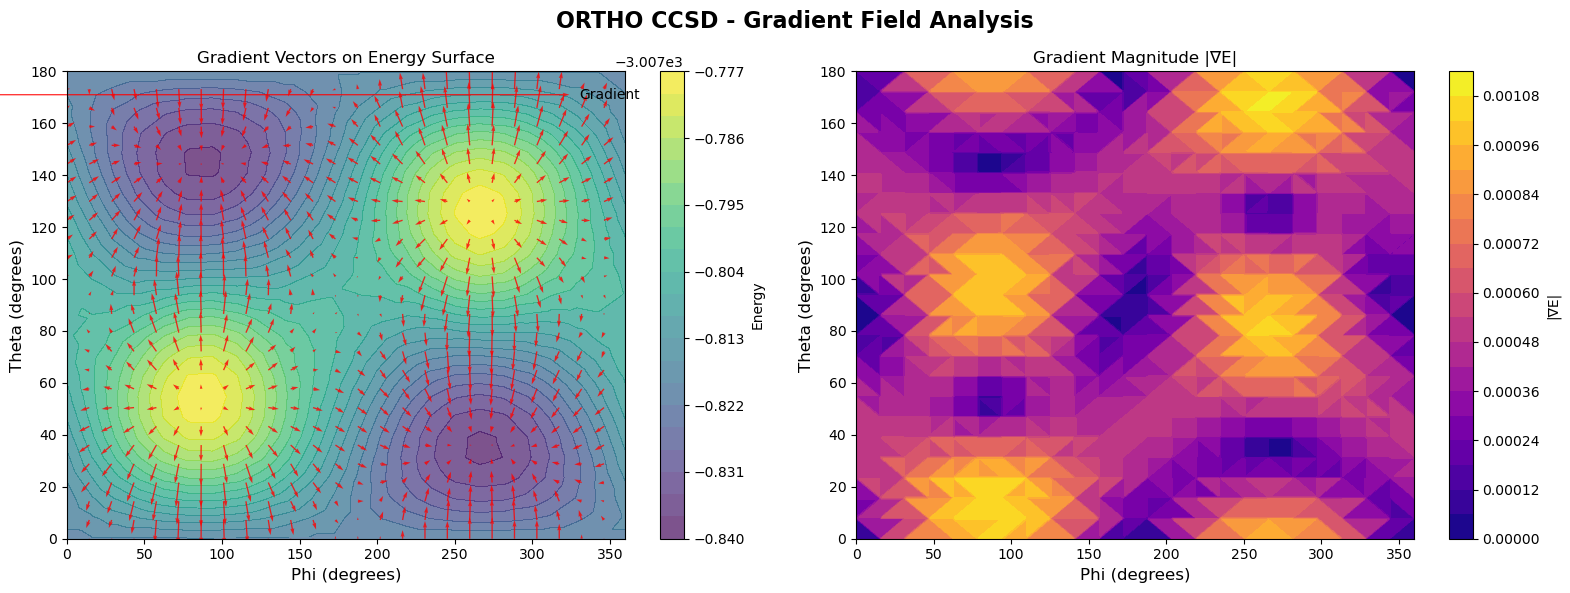


Gradient Statistics for ORTHO CCSD:
------------------------------------------------------------
∂E/∂φ range: [-4.615151e-04, 4.401125e-04]
∂E/∂θ range: [-1.074949e-03, 1.082280e-03]
|∇E| mean: 5.222960e-04
|∇E| max: 1.083233e-03


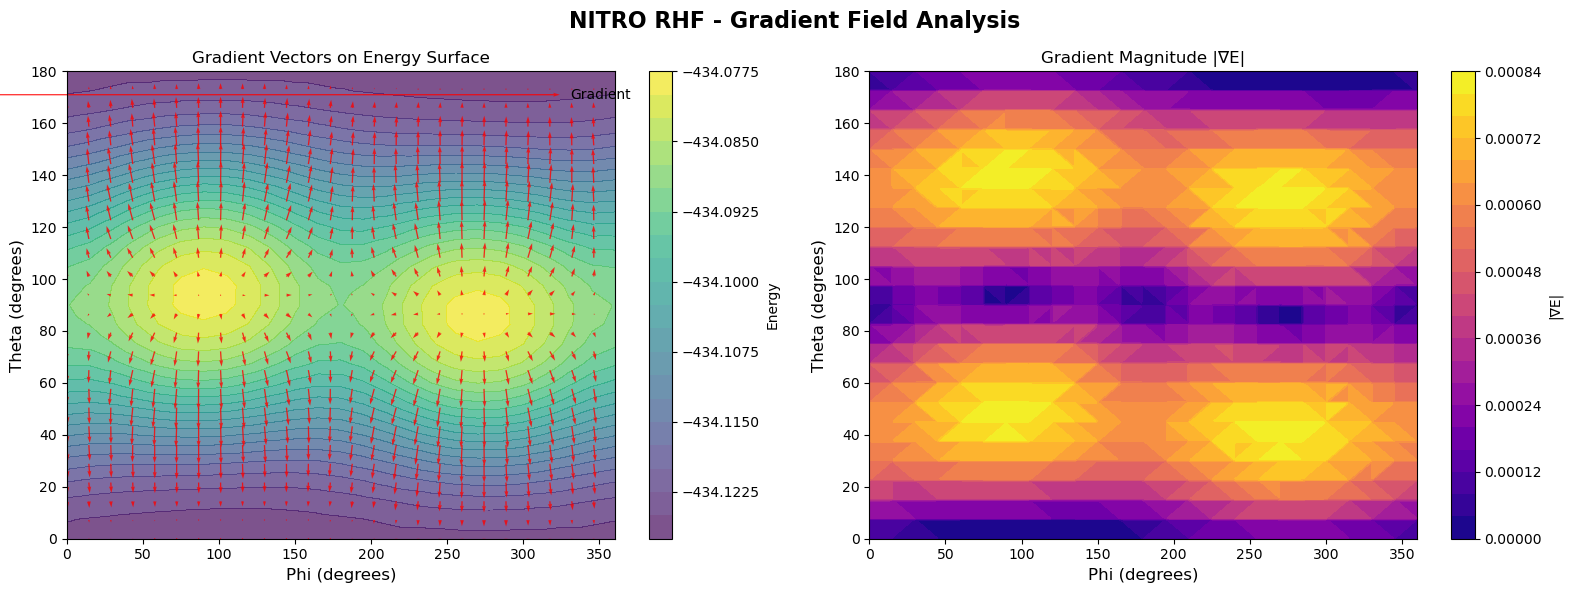


Gradient Statistics for NITRO RHF:
------------------------------------------------------------
∂E/∂φ range: [-2.138713e-04, 2.097271e-04]
∂E/∂θ range: [-8.261118e-04, 8.261118e-04]
|∇E| mean: 4.747572e-04
|∇E| max: 8.266736e-04


In [4]:
# Add this to your load_and_analyze_dataset function, or run separately:

def plot_gradient_field(phi_grid, theta_grid, grid_values, dataset_name, 
                        subsample=4):
    """
    Create a gradient field visualization showing energy gradients.
    
    Parameters:
    -----------
    phi_grid : 1D array
        Phi coordinates
    theta_grid : 1D array
        Theta coordinates
    grid_values : 2D array
        Interpolated energy values
    dataset_name : str
        Name for plot title
    subsample : int
        Plot every Nth arrow (to avoid overcrowding)
    """
    
    # Compute negative of the gradients (aka force) 
    dE_dtheta, dE_dphi = np.gradient(grid_values, theta_grid, phi_grid)
    dE_dtheta *= -1
    dE_dphi *= -1
    
    # Create meshgrid for plotting
    PH, TH = np.meshgrid(phi_grid, theta_grid)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{dataset_name} - Gradient Field Analysis', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Gradient field over energy contours
    contour = axes[0].contourf(PH, TH, grid_values, levels=20, 
                               cmap='viridis', alpha=0.7)
    
    # Subsample for cleaner arrows
    quiver = axes[0].quiver(PH[::subsample, ::subsample], 
                           TH[::subsample, ::subsample],
                           dE_dphi[::subsample, ::subsample],
                           dE_dtheta[::subsample, ::subsample],
                           color='red', alpha=0.8, scale=None)
    
    axes[0].set_xlabel('Phi (degrees)', fontsize=12)
    axes[0].set_ylabel('Theta (degrees)', fontsize=12)
    axes[0].set_title('Gradient Vectors on Energy Surface')
    plt.colorbar(contour, ax=axes[0], label='Energy')
    axes[0].quiverkey(quiver, 0.9, 0.95, 1, 'Gradient', labelpos='E')
    
    # Plot 2: Gradient magnitude
    gradient_magnitude = np.sqrt(dE_dphi**2 + dE_dtheta**2)
    
    magnitude_plot = axes[1].contourf(PH, TH, gradient_magnitude, 
                                      levels=20, cmap='plasma')
    axes[1].set_xlabel('Phi (degrees)', fontsize=12)
    axes[1].set_ylabel('Theta (degrees)', fontsize=12)
    axes[1].set_title('Gradient Magnitude |∇E|')
    plt.colorbar(magnitude_plot, ax=axes[1], label='|∇E|')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nGradient Statistics for {dataset_name}:")
    print(f"{'-'*60}")
    print(f"∂E/∂φ range: [{np.nanmin(dE_dphi):.6e}, {np.nanmax(dE_dphi):.6e}]")
    print(f"∂E/∂θ range: [{np.nanmin(dE_dtheta):.6e}, {np.nanmax(dE_dtheta):.6e}]")
    print(f"|∇E| mean: {np.nanmean(gradient_magnitude):.6e}")
    print(f"|∇E| max: {np.nanmax(gradient_magnitude):.6e}")
    
    return dE_dphi, dE_dtheta, gradient_magnitude


# Use it with your results:
dE_dphi_meta, dE_dtheta_meta, grad_mag_meta = plot_gradient_field(
    meta_results['phi_grid'], 
    meta_results['theta_grid'], 
    meta_results['grid_values'],
    "META CCSD",
    subsample=20  # Adjust to control arrow density
)

dE_dphi_ortho, dE_dtheta_ortho, grad_mag_ortho = plot_gradient_field(
    ortho_results['phi_grid'], 
    ortho_results['theta_grid'], 
    ortho_results['grid_values'],
    "ORTHO CCSD",
    subsample=20
)

dE_dphi_nitro, dE_dtheta_nitro, grad_mag_nitro = plot_gradient_field(
    nitro_results['phi_grid'], 
    nitro_results['theta_grid'], 
    nitro_results['grid_values'],
    "NITRO RHF",
    subsample=20
)

In [5]:
import numpy as np
import re

def parse_theta_phi_trajectory(filename):
    """
    Parse trajectory file containing lines like:
    Step 0  E=-434.0924835505  phi=37.324  theta=72.741
    
    Returns:
    --------
    phi_vals : np.ndarray
    theta_vals : np.ndarray
    """
    t_values = []
    phi_vals = []
    theta_vals = []
    E_vals = []

    ts_to_fs = 0.24188843265857
    hartree_to_kcalmol = 627.5094740631
    t_idx = 0
    with open(filename, 'r') as f:
        for line in f:
            if 'E=' in line and 'phi=' in line and 'theta=' in line:
                # Extract using regex
                phi_match = re.search(r'phi=([-\d.]+)', line)
                theta_match = re.search(r'theta=([-\d.]+)', line)
                E_match = re.search(r'E=([-\d.]+)', line)
                
                if E_match and phi_match and theta_match:
                    phi_vals.append(float(phi_match.group(1)))
                    Ev = float(E_match.group(1))
                    E_vals.append(Ev * hartree_to_kcalmol)
                    tv = float(theta_match.group(1))
                    if tv > 100:
                        tv_flip = 180 - tv
                        tv = tv_flip
                    theta_vals.append(tv)
                    #theta_vals.append(float(theta_match.group(1)))
            t_values.append(t_idx * ts_to_fs)
            t_idx += 1
    
    return np.array(phi_vals), np.array(theta_vals), np.array(t_values), np.array(E_vals)

phi_traj, theta_traj, t_values, E_vals = parse_theta_phi_trajectory("CCSD_DATA/nitrobenzene_theta_phi_trajectory.txt")

# offset E_vals by mid-range value
min_E = np.min(E_vals)
max_E = np.max(E_vals)
med_E = (max_E - min_E)/2
E_vals = E_vals - min_E - med_E
print(np.min(E_vals))
print(np.max(E_vals))

-10.806481654202798
10.806481654202798


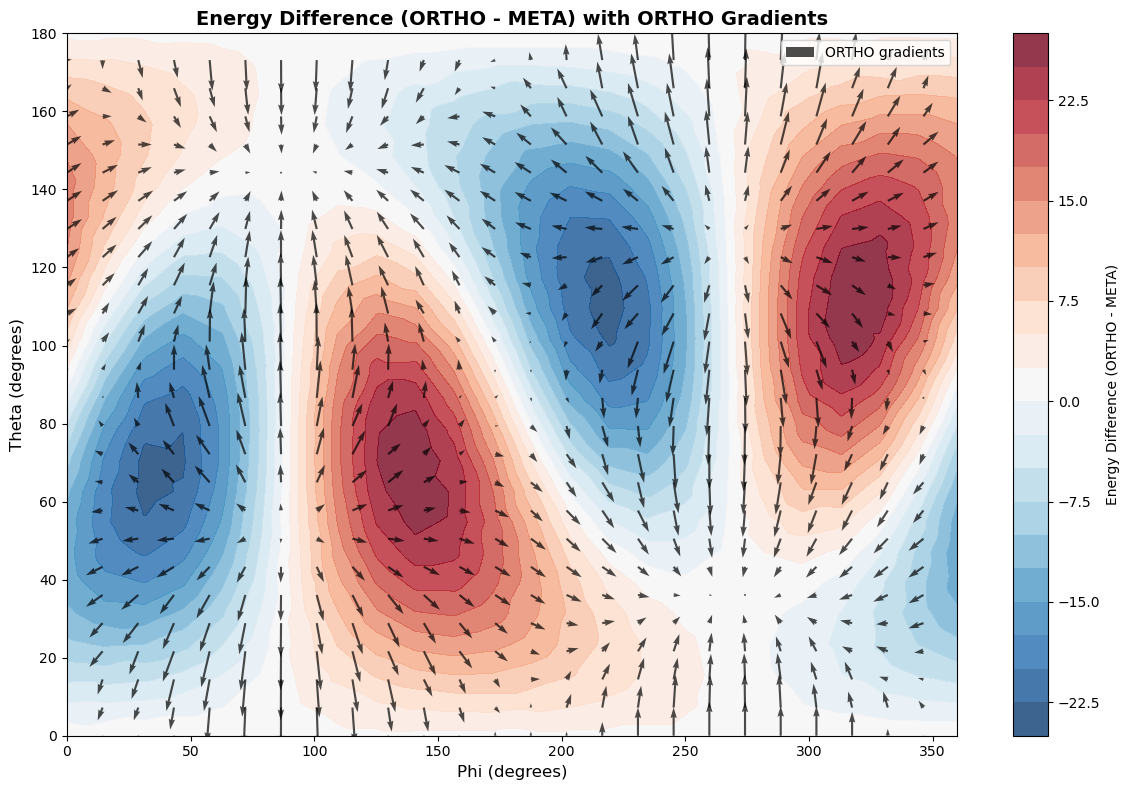


Energy Difference Statistics:
------------------------------------------------------------
Mean difference: 1.507286e+00
Std difference: 1.154111e+01
Max difference: 2.734684e+01
Min difference: -2.370978e+01

ORTHO Gradient Magnitude:
  Mean: 5.222960e-04
  Max: 1.083233e-03


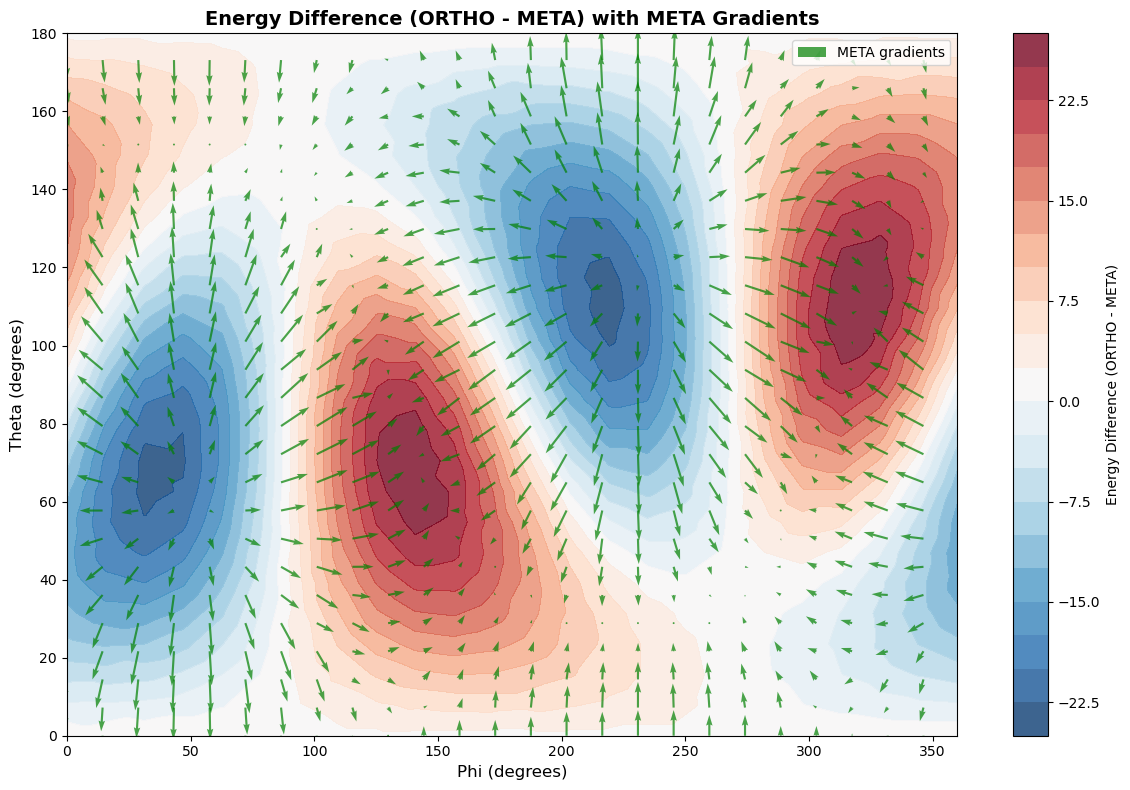


Energy Difference Statistics:
------------------------------------------------------------
Mean difference: 1.507286e+00
Std difference: 1.154111e+01
Max difference: 2.734684e+01
Min difference: -2.370978e+01

META Gradient Magnitude:
  Mean: 8.405018e-04
  Max: 1.605639e-03


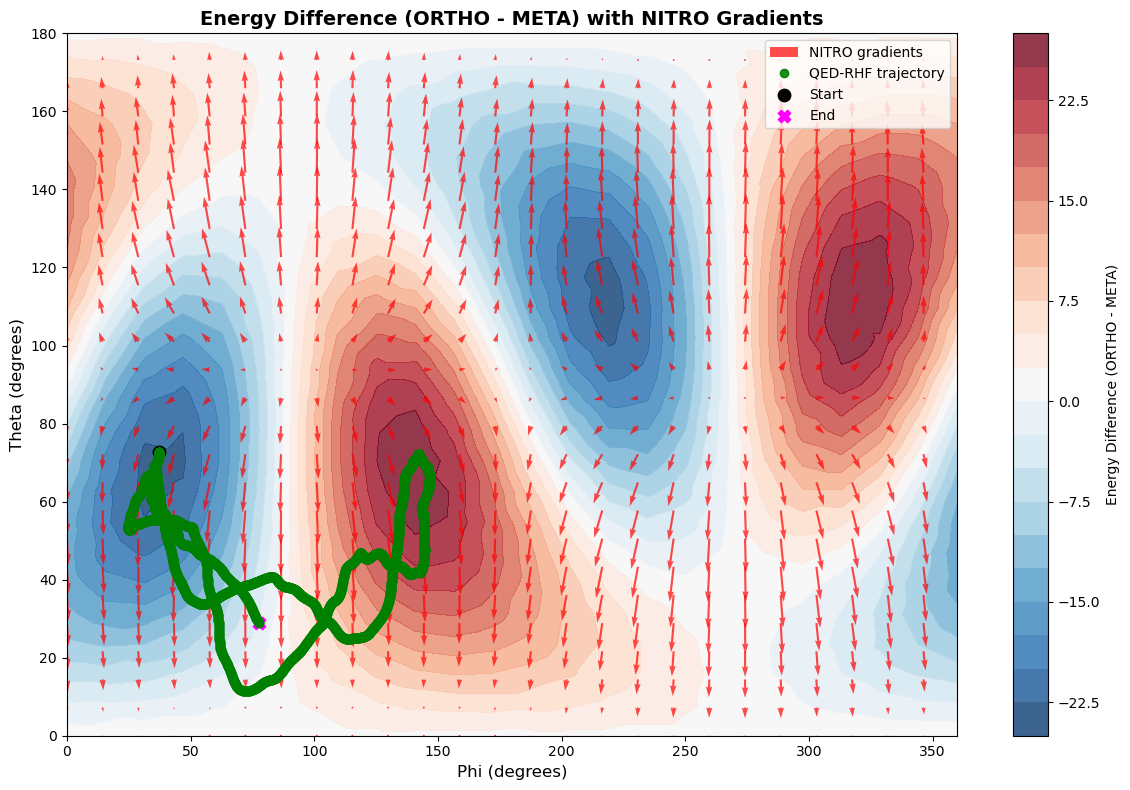


Energy Difference Statistics:
------------------------------------------------------------
Mean difference: 1.507286e+00
Std difference: 1.154111e+01
Max difference: 2.734684e+01
Min difference: -2.370978e+01

NITRO Gradient Magnitude:
  Mean: 4.747572e-04
  Max: 8.266736e-04


In [6]:
def plot_energy_difference_with_gradients(meta_results, ortho_results, nitro_results,
                                          gradient_source='ortho',
                                          subsample=4, file_name="test.png", trajectory=None):
    """
    Plot energy difference (ortho - meta) with gradient vectors overlaid.
    
    Parameters:
    -----------
    meta_results : dict
        Results from META dataset
    ortho_results : dict
        Results from ORTHO dataset
    gradient_source : str
        Which gradients to overlay: 'ortho', 'meta', or 'both'
    subsample : int
        Plot every Nth arrow
    file_name : string
        Name of the file to save plot in
    trajectory : Optional tuple 
        Trajectory of phi and theta containing the dynamics subject to the gradient field
    """
    hartree_to_kcalmol = 627.5094740631
    
    # Calculate energy difference
    energy_diff = (ortho_results['grid_values'] - meta_results['grid_values']) * hartree_to_kcalmol
    
    # Get grids (assuming same grid for both)
    phi_grid = meta_results['phi_grid']
    theta_grid = meta_results['theta_grid']
    PH, TH = np.meshgrid(phi_grid, theta_grid)
    
    # Compute gradients for selected source(s)
    if gradient_source in ['ortho', 'both']:
        dE_dtheta_ortho, dE_dphi_ortho = np.gradient(
            ortho_results['grid_values'], theta_grid, phi_grid)

        # get negative of gradient -> force
        dE_dtheta_ortho *= -1
        dE_dphi_ortho *= -1
    
    if gradient_source in ['meta', 'both']:
        dE_dtheta_meta, dE_dphi_meta = np.gradient(
            meta_results['grid_values'], theta_grid, phi_grid)

        # get negative of gradient -> force
        dE_dtheta_meta *= -1
        dE_dphi_meta *= -1

    if gradient_source in ['nitro', 'both']:
        dE_dtheta_nitro, dE_dphi_nitro = np.gradient(
            nitro_results['grid_values'], theta_grid, phi_grid)

        # get negative of gradient -> force
        dE_dtheta_nitro *= -1
        dE_dphi_nitro *= -1
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot energy difference as contours
    contour = ax.contourf(PH, TH, energy_diff, levels=20, 
                         cmap='RdBu_r', alpha=0.8)
    
    # Overlay gradient vectors
    if gradient_source == 'ortho':
        quiver = ax.quiver(PH[::subsample, ::subsample], 
                          TH[::subsample, ::subsample],
                          dE_dphi_ortho[::subsample, ::subsample],
                          dE_dtheta_ortho[::subsample, ::subsample],
                          color='black', alpha=0.7, 
                          label='ORTHO gradients')
        
    elif gradient_source == 'meta':
        quiver = ax.quiver(PH[::subsample, ::subsample], 
                          TH[::subsample, ::subsample],
                          dE_dphi_meta[::subsample, ::subsample],
                          dE_dtheta_meta[::subsample, ::subsample],
                          color='green', alpha=0.7,
                          label='META gradients')

    elif gradient_source == "nitro":
        quiver = ax.quiver(PH[::subsample, ::subsample], 
                          TH[::subsample, ::subsample],
                          dE_dphi_nitro[::subsample, ::subsample],
                          dE_dtheta_nitro[::subsample, ::subsample],
                          color='red', alpha=0.7,
                          label='NITRO gradients')
        
    elif gradient_source == 'both':
        quiver1 = ax.quiver(PH[::subsample, ::subsample], 
                           TH[::subsample, ::subsample],
                           dE_dphi_ortho[::subsample, ::subsample],
                           dE_dtheta_ortho[::subsample, ::subsample],
                           color='black', alpha=0.6,
                           label='ORTHO gradients', width=0.003)
        
        quiver2 = ax.quiver(PH[::subsample, ::subsample], 
                           TH[::subsample, ::subsample],
                           dE_dphi_meta[::subsample, ::subsample],
                           dE_dtheta_meta[::subsample, ::subsample],
                           color='green', alpha=0.6,
                           label='META gradients', width=0.003)

    # Overlay trajectory if provided
    if trajectory is not None:
        phi_traj, theta_traj = trajectory
        
        ax.plot(phi_traj, theta_traj, 'go',
                #color='go',
                #linewidth=1.5,
                alpha=0.9,
                label='QED-RHF trajectory')
        
        # Mark starting point
        ax.scatter(phi_traj[0], theta_traj[0],
                   color='black', s=80, marker='o',
                   label='Start')
        
        # Mark end point
        ax.scatter(phi_traj[-1], theta_traj[-1],
                   color='magenta', s=80, marker='X',
                   label='End')
        
    ax.set_xlabel('Phi (degrees)', fontsize=12)
    ax.set_ylabel('Theta (degrees)', fontsize=12)
    ax.set_title(f'Energy Difference (ORTHO - META) with {gradient_source.upper()} Gradients',
                fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, label='Energy Difference (ORTHO - META)')
    
    # Add legend
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(file_name, dpi=200)
    plt.show()
    # Print statistics
    print(f"\nEnergy Difference Statistics:")
    print(f"{'-'*60}")
    print(f"Mean difference: {np.nanmean(energy_diff):.6e}")
    print(f"Std difference: {np.nanstd(energy_diff):.6e}")
    print(f"Max difference: {np.nanmax(energy_diff):.6e}")
    print(f"Min difference: {np.nanmin(energy_diff):.6e}")
    
    if gradient_source in ['ortho', 'both']:
        grad_mag_ortho = np.sqrt(dE_dphi_ortho**2 + dE_dtheta_ortho**2)
        print(f"\nORTHO Gradient Magnitude:")
        print(f"  Mean: {np.nanmean(grad_mag_ortho):.6e}")
        print(f"  Max: {np.nanmax(grad_mag_ortho):.6e}")
    
    if gradient_source in ['meta', 'both']:
        grad_mag_meta = np.sqrt(dE_dphi_meta**2 + dE_dtheta_meta**2)
        print(f"\nMETA Gradient Magnitude:")
        print(f"  Mean: {np.nanmean(grad_mag_meta):.6e}")
        print(f"  Max: {np.nanmax(grad_mag_meta):.6e}")

    if gradient_source in ['nitro', 'both']:
        grad_mag_nitro = np.sqrt(dE_dphi_nitro**2 + dE_dtheta_nitro**2)
        print(f"\nNITRO Gradient Magnitude:")
        print(f"  Mean: {np.nanmean(grad_mag_nitro):.6e}")
        print(f"  Max: {np.nanmax(grad_mag_nitro):.6e}")


# Usage examples:

# Overlay ORTHO gradients on difference plot
plot_energy_difference_with_gradients(meta_results, ortho_results, nitro_results,
                                     gradient_source='ortho', subsample=20, file_name="ortho_grad.png")

# Overlay META gradients on difference plot
plot_energy_difference_with_gradients(meta_results, ortho_results, nitro_results,
                                     gradient_source='meta', subsample=20, file_name="meta_grad.png")

# Overlay META gradients on difference plot
plot_energy_difference_with_gradients(meta_results, ortho_results, nitro_results,
                                     gradient_source='nitro', subsample=20, file_name="nitro_grad.png", trajectory=(phi_traj, theta_traj))
# Overlay both (compare gradient directions)
#plot_energy_difference_with_gradients(meta_results, ortho_results, 
#                                     gradient_source='both', subsample=6)

In [7]:
from scipy.interpolate import RegularGridInterpolator

def compute_time_in_ortho_favored_zone(meta_results, ortho_results, phi_traj, theta_traj):
    
    hartree_to_kcalmol = 627.5094740631
    
    energy_diff = (ortho_results['grid_values'] -
                   meta_results['grid_values']) * hartree_to_kcalmol
    
    phi_grid = meta_results['phi_grid']
    theta_grid = meta_results['theta_grid']
    
    interpolator = RegularGridInterpolator(
        (theta_grid, phi_grid),
        energy_diff
    )
    
    points = np.column_stack([theta_traj, phi_traj])
    deltaE_traj = interpolator(points)
    
    # Fraction of time ortho favored
    ortho_fraction = np.mean(deltaE_traj < 0.0)
    
    return ortho_fraction, deltaE_traj

fraction, deltaE_traj = compute_time_in_ortho_favored_zone(
    meta_results, ortho_results,
    phi_traj, theta_traj
)

print(f"Fraction of time in ortho-favored region: {fraction:.3f}")

Fraction of time in ortho-favored region: 0.555


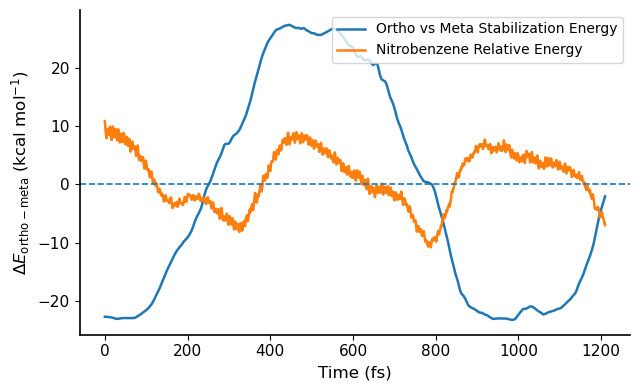

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_deltaE_timeseries(t_values, deltaE_traj1, deltaE_traj2,
                           file_name="deltaE_vs_time.png"):

    plt.figure(figsize=(6.5, 4.0))

    # Main trajectory line
    plt.plot(t_values,
             deltaE_traj1,
             linewidth=1.8, label="Ortho vs Meta Stabilization Energy")

    plt.plot(t_values,
             deltaE_traj2,
             linewidth=1.8, label="Nitrobenzene Relative Energy")
    

    # Zero reference line
    plt.axhline(0.0,
                linestyle='--',
                linewidth=1.2)

    # Axis labels (with proper math formatting)
    plt.xlabel("Time (fs)", fontsize=12)
    plt.ylabel(r"$\Delta E_{\mathrm{ortho-meta}}$ (kcal mol$^{-1}$)",
               fontsize=12)

    # Remove top/right spines (clean journal look)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Thicker axis lines
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # Ticks styling
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.tight_layout()
    plt.savefig(file_name, dpi=600, bbox_inches="tight")
    plt.legend()
    plt.show()

plot_deltaE_timeseries(t_values, deltaE_traj, E_vals, file_name="deltaE_vs_time.png")


In [ ]:
### THIS CELL READS FROM ORTHO, META ONLY, NO NITRO!

def load_and_analyze_dataset(df, dataset_name, n_grid_points=24):
    """
    Perform interpolation and accuracy analysis on a molecular energy dataset.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns 'theta', 'phi', 'value'
    dataset_name : str
        Name of the dataset for labeling plots
    n_grid_points : int
        Number of grid points for interpolation in each dimension
    
    Returns:
    --------
    dict : Dictionary containing interpolation results and statistics
    """
    
    print(f"\n{'='*60}")
    print(f"Processing: {dataset_name}")
    print(f"{'='*60}")
    
    # Extract values
    theta_vals = df['theta'].values
    phi_vals = df['phi'].values
    values = df['value'].values
    
    print(f"Data points: {len(values)}")
    print(f"Theta range: [{theta_vals.min():.4f}, {theta_vals.max():.4f}]")
    print(f"Phi range: [{phi_vals.min():.4f}, {phi_vals.max():.4f}]")
    print(f"Value range: [{values.min():.6e}, {values.max():.6e}]")
    
    # Create pivot table
    pivot_df = df.pivot_table(index='theta', columns='phi', values='value')
    pivot_df.index = pivot_df.index.round(4)
    pivot_df.columns = pivot_df.columns.round(4)
    
    # Create fine grid for interpolation
    # phi (x-axis): 0-360 degrees
    # theta (y-axis): 0-180 degrees
    phi_grid = np.linspace(phi_vals.min(), phi_vals.max(), n_grid_points)
    theta_grid = np.linspace(theta_vals.min(), theta_vals.max(), n_grid_points)
    PH, TH = np.meshgrid(phi_grid, theta_grid)  # phi varies along x, theta along y
    
    # Perform interpolation on grid
    grid_values = griddata((phi_vals, theta_vals), values, 
                          (PH, TH), method='linear')
    
    # Test accuracy: interpolate at original data points
    interpolated_at_original = griddata((phi_vals, theta_vals), values,
                                       (phi_vals, theta_vals), method='linear')
    
    # Calculate errors
    absolute_errors = np.abs(values - interpolated_at_original)
    relative_errors = np.abs((values - interpolated_at_original) / values) * 100
    
    # Remove NaN values (edge points)
    valid_mask = ~np.isnan(interpolated_at_original)
    absolute_errors_clean = absolute_errors[valid_mask]
    relative_errors_clean = relative_errors[valid_mask]
    values_clean = values[valid_mask]
    
    # Print statistics
    print(f"\nInterpolation Accuracy Assessment:")
    print(f"{'-'*60}")
    print(f"Successfully interpolated: {np.sum(valid_mask)}/{len(values)}")
    print(f"\nAbsolute Error Statistics:")
    print(f"  Mean: {np.mean(absolute_errors_clean):.6e}")
    print(f"  Std:  {np.std(absolute_errors_clean):.6e}")
    print(f"  Max:  {np.max(absolute_errors_clean):.6e}")
    print(f"  Min:  {np.min(absolute_errors_clean):.6e}")
    print(f"\nRelative Error Statistics (%):")
    print(f"  Mean: {np.mean(relative_errors_clean):.4f}%")
    print(f"  Std:  {np.std(relative_errors_clean):.4f}%")
    print(f"  Max:  {np.max(relative_errors_clean):.4f}%")
    
    # Find worst interpolation points
    worst_indices = np.argsort(absolute_errors_clean)[-5:]
    valid_indices = np.where(valid_mask)[0]
    
    print(f"\n5 Worst Interpolation Points:")
    print(f"{'-'*60}")
    for i, idx in enumerate(worst_indices):
        original_idx = valid_indices[idx]
        print(f"{i+1}. Theta={theta_vals[original_idx]:.4f}, Phi={phi_vals[original_idx]:.4f}")
        print(f"   Original: {values[original_idx]:.6f}, Interpolated: {interpolated_at_original[original_idx]:.6f}")
        print(f"   Error: {absolute_errors_clean[idx]:.6e}, Relative: {relative_errors_clean[idx]:.4f}%")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'{dataset_name} - Interpolation Analysis', fontsize=16, fontweight='bold')
    
    # 1. Original data scatter plot
    scatter = axes[0, 0].scatter(df['phi'], df['theta'], c=df['value'], 
                                cmap='viridis', s=50, edgecolors='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Phi (degrees)')
    axes[0, 0].set_ylabel('Theta (degrees)')
    axes[0, 0].set_title('Original Data Points')
    plt.colorbar(scatter, ax=axes[0, 0], label='Energy')
    
    # 2. Interpolated surface
    contour = axes[0, 1].contourf(PH, TH, grid_values, levels=20, cmap='viridis')
    axes[0, 1].scatter(phi_vals, theta_vals, c='red', s=10, alpha=0.5, label='Original points')
    axes[0, 1].set_xlabel('Phi (degrees)')
    axes[0, 1].set_ylabel('Theta (degrees)')
    axes[0, 1].set_title('Interpolated Surface')
    axes[0, 1].legend()
    plt.colorbar(contour, ax=axes[0, 1], label='Energy')
    
    # 3. Absolute error distribution
    axes[1, 0].hist(absolute_errors_clean, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1, 0].set_xlabel('Absolute Error')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Absolute Errors')
    axes[1, 0].axvline(np.mean(absolute_errors_clean), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(absolute_errors_clean):.2e}')
    axes[1, 0].legend()
    
    # 4. Error vs original value
    axes[1, 1].scatter(values_clean, absolute_errors_clean, alpha=0.5, s=20, color='steelblue')
    axes[1, 1].set_xlabel('Original Energy Value')
    axes[1, 1].set_ylabel('Absolute Error')
    axes[1, 1].set_title('Error vs Original Value')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return results
    return {
        'dataset_name': dataset_name,
        'pivot_df': pivot_df,
        'phi_grid': phi_grid,
        'theta_grid': theta_grid,
        'PH': PH,
        'TH': TH,
        'grid_values': grid_values,
        'mean_abs_error': np.mean(absolute_errors_clean),
        'mean_rel_error': np.mean(relative_errors_clean),
        'max_abs_error': np.max(absolute_errors_clean),
        'n_valid': np.sum(valid_mask),
        'n_total': len(values)
    }


# ===== LOAD ALL DATASETS =====

# META dataset
print("Loading META dataset...")
meta_df = pd.read_csv('CCSD_DATA/meta_ccsd_energies.txt', sep='\s+', header=None, 
                      names=['filename', 'value'])
pattern = r"theta_(.*?)_phi_(.*?)\.json"
meta_df[['theta', 'phi']] = meta_df['filename'].str.extract(pattern).astype(float)
meta_df = meta_df[['theta', 'phi', 'value']]
print(f"Loaded {len(meta_df)} rows.")


# ORTHO dataset
print("\nLoading ORTHO dataset...")
ortho_df = pd.read_csv('CCSD_DATA/ortho_ccsd_energies.txt',
                       delim_whitespace=True,
                       header=None,
                       names=['theta', 'phi', 'value'])
print(f"Loaded {len(ortho_df)} rows.")


# ===== ANALYZE ALL DATASETS =====

meta_results = load_and_analyze_dataset(meta_df, "META CCSD", n_grid_points=500)
ortho_results = load_and_analyze_dataset(ortho_df, "ORTHO CCSD", n_grid_points=500)


# ===== COMPARISON SUMMARY =====

print(f"\n{'='*60}")
print("COMPARISON SUMMARY")
print(f"{'='*60}")

results = [meta_results, ortho_results]

print(f"\n{'Dataset':<15} {'Points':<10} {'Valid':<10} {'Mean Abs Err':<15} {'Mean Rel Err %':<15}")
print(f"{'-'*70}")
for r in results:
    print(f"{r['dataset_name']:<15} {r['n_total']:<10} {r['n_valid']:<10} "
          f"{r['mean_abs_error']:<15.6e} {r['mean_rel_error']:<15.4f}")

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Interpolation Quality Comparison', fontsize=16, fontweight='bold')

for i, r in enumerate(results):
    axes[i].contourf(r['PH'], r['TH'], r['grid_values'], levels=20, cmap='viridis')
    axes[i].set_xlabel('Phi (degrees)')
    axes[i].set_ylabel('Theta (degrees)')
    axes[i].set_title(f"{r['dataset_name']}\nMean Abs Error: {r['mean_abs_error']:.2e}")

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")